### Notes:

* python script stores result of the simulation in a predetermined location
* jupyter notebook shows visualizations of the results from solidity implementation and cadCAD model and error metrics

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import pandas as pd
import datetime as dt
from enum import Enum
import csv

import sys
sys.path.append('./models')

In [2]:
#python stores a file containing Kp, Ki and a time series of market prices 
#(an array of tuples, or two arrays, containing a timestamp and the price, 
#or the time elapsed and the price change - we can go with whatever is easier to implement on the JS side)

#instead of file name being hardcoded, we could have it stored in an environment 
#variable that both python and JS read from
Kp = -.25/3600/96
Ki = 0
t = 652
delta_t = [3600] * t

# with open('./test/data/market_prices.csv', 'w') as market_prices_csv:
#     wr = csv.writer(market_prices_csv, delimiter=',')
#     wr.writerow(market_prices)

with open('./test/data/market_prices.csv') as f:
    reader = csv.reader(f)
    market_prices = [float(entry) for entry in list(reader)[0]]

save_dir = "./cross-model/truffle/test/saved_sims/pi_second/raw/custom-config-sim.txt"

config_file = {
  "Kp": str(int(Kp*1e18)),
  "Ki": str(int(Ki*1e18)),
  "noise_barrier": "1000000000000000000",
  "per_second_leak": "1000000000000000000000000000",
  "oracle_initial_price": "2000000000000000000",
  "initial_redemption_price": "2000000000000000000000000000",
  "delta_t": [str(i) for i in delta_t],
  "market_prices": [str(int(i*1e18)) for i in market_prices],
  "save_dir": save_dir
}

import json
with open('./cross-model/truffle/test/config/pi_second_raw.json', 'w') as fp:
    json.dump(config_file, fp)
    
config_file = {
  "kp": Kp,
  "ki": Ki,
  #"noise_barrier": 1000000000000000000,
  #"per_second_leak": 1000000000000000000000000000,
  #"oracle_initial_price": 2000000000000000000,
  #"initial_redemption_price": 2000000000000000000000000000,
  "delta_t": delta_t,
  "market_prices": market_prices,
}

In [19]:
# Compile, test, and deploy contracts to Ganache
!npm run pi-raw-second-imported-config --prefix './cross-model/truffle'


> geb-rrfm-truffle-sims@1.0.0 pi-raw-second-imported-config /Users/bscholtz/workspace/reflexer/cross-model/truffle
> npx truffle test test/pi_raw_second_imported_config.js

░░░░⠂⠂⠂⠂⠂⠂⸩ ⠼ install:truffle: sill doSerial install 1152json C- Fetching solc version list from solc-bin. Attempt #1

Compiling your contracts...
> Compiling ./cross-model/truffle/contracts/Migrations.sol
> Compiling ./cross-model/truffle/contracts/mock/AGUpdater.sol
> Compiling ./cross-model/truffle/contracts/mock/MockOracleRelayer.sol
> Compiling ./cross-model/truffle/contracts/mock/MockRateSetter.sol
> Compiling ./cross-model/truffle/contracts/mock/MockTreasury.sol
> Compiling ./cross-model/truffle/contracts/mock/SeedProposerUpdater.sol
> Compiling ./cross-model/truffle/contracts/oracle/MockFeed.sol
> Compiling ./cross-model/truffle/contracts/setter/RateSetter.sol
> Compiling ./cross-model/truffle/contracts/setter/RateSetterMath.sol
> Compiling ./cross-model/truffle/contracts/token/Address.sol
> Compiling ./cro

[redemptionRate](https://github.com/reflexer-labs/geb-rrfm-truffle-sims/blob/master/contracts/mock/MockOracleRelayer.sol#L14) = $1+d_t$ (units: per second)  
$p_{t+\Delta{t}} = p_{t} (1+d_t)^{\Delta{t}}$ where $\Delta{t}$ is measured in seconds  
Meaning:
* $d_t > 0$ implies $redemptionRate > 1$  
* $d_t < 0$ implies $redemptionRate < 1$  


In the results dataset this is the PerSecondRedemptionRate column

In [20]:
from models.system_model.model.state_variables import state_variables

def pre_process_initial_conditions(genesis_dict):
    base_genesis_states = genesis_dict.copy()
    for k in base_genesis_states.keys():
        if k in config_file:
            try:
                base_genesis_states[k] = config_file[k][0]
            except:
                base_genesis_states[k] = config_file[k]
    return base_genesis_states

test_specific_initial_conditions = pre_process_initial_conditions(state_variables)

In [21]:
from models.system_model.model.parts.sys_params import params

def pre_process_params_dict(params_dict):
    base_params_dict = params_dict.copy()
    for k in config_file.keys():
        if type(config_file[k]) == list:
            base_params_dict[k] = [config_file[k]]
        else:
            try:
                base_params_dict[k] = [config_file[k]]
            except OverflowError:
                print(config_file[k])
                raise
    return base_params_dict

test_specific_params = pre_process_params_dict(params)

In [22]:
T = 0
for k in config_file.keys():
    if type(config_file[k]) == list:
        T = len(config_file[k])-1
        break

In [23]:
def test_specific_resolve_time_passed(params, substep, state_history, state):
    index = state['timestep']+1
    value = params['delta_t'][index]
    return {'seconds_passed': value}

def test_specific_update_market_price(params, substep, state_history, state, policy_input):
    key = 'market_price'  
    index = state['timestep']
    value = params['market_prices'][index]
    return key, value


from models.system_model.model.parts.markets import resolve_time_passed, update_market_price
from models.system_model.model.partial_state_update_blocks import partial_state_update_blocks

for psub in partial_state_update_blocks:
    for psub_part in psub.values():
        if type(psub_part)==dict:
            for k,v in psub_part.items():
                if v == resolve_time_passed:
                    psub_part[k] = test_specific_resolve_time_passed
                if v == update_market_price:
                    psub_part[k] = test_specific_update_market_price

In [24]:
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs

del configs[:]

exp = Experiment()

sim_config_dict = {
    'T': range(T),
    'N': 1,
    'M': test_specific_params
}
c = config_sim(sim_config_dict)

exp.append_configs(
    initial_state=test_specific_initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=c #preprocessed dictionaries containing simulation parameters
)

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(exec_mode.local_mode)
executor = Executor(local_mode_ctx, configs) # Pass the configuration object inside an array
raw_result, tensor, sessions = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (651, 23, 1, 15)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.36s


In [25]:
full = pd.DataFrame(raw_result)

In [26]:
max_substep = max(full.substep)
df = full.copy()
df = df[(df.substep==max_substep) | (df.substep==0)]

In [27]:
data = pd.read_csv(save_dir, sep=" ", header=None, skiprows=1)
data.columns = [x.replace(' ','') for x in pd.read_csv(save_dir, sep="|", nrows=1).columns]

for c in data.columns:
    data[c]=data[c].apply(float)
#define normalizing constants
WAD = 10**18
RAY = 10**27
RAD = 10**45
#normalize data to "USD" dimension
data['MarketPrice(USD)'] = data['MarketPrice(WAD)']/WAD
data['RedemptionPrice(USD)'] = data['RedemptionPrice(RAY)']/RAY
data['PerSecondRedemptionRate(float)'] = data['PerSecondRedemptionRate(RAY)']/RAY - 1
data['time'] = data['DelaySinceLastUpdate'].cumsum()
data['timestamp'] = state_variables['timestamp'] + data['time'].apply(lambda x: dt.timedelta(seconds=x))

In [46]:
combined = df.merge(data, how='inner', on=['timestamp'])
combined

,error_star,error_hat,old_error_star,old_error_hat,error_star_integral,error_hat_integral,error_star_derivative,error_hat_derivative,target_rate,target_price,...,RedemptionRateTimeline(Seconds),Proportional(NoGain),Proportional(WithGain),Integral(NoGain),Integral(WithGain),DelaySinceLastUpdate,MarketPrice(USD),RedemptionPrice(USD),PerSecondRedemptionRate(float),time
0,-0.006753,-0.007045,0.0,0.0,0.0,-12.680175,-0.000002,-0.000002,4.884961e-09,2.000035,...,1.0,-3.520968e+25,2.546997e+19,0.000000e+00,0.0,3600.0,2.035210,2,2.547e-08,3600.0
1,-0.025910,-0.027610,0.0,0.0,0.0,-75.057864,-0.000005,-0.000005,1.874243e-08,2.000170,...,1.0,-6.569578e+24,4.752299e+18,-7.520267e+28,0.0,3600.0,2.006753,2.00018,4.7523e-09,7200.0
2,-0.051305,-0.052354,0.0,0.0,0.0,-218.993087,-0.000007,-0.000007,3.711308e-08,2.000437,...,1.0,-2.572709e+25,1.861045e+19,-1.333528e+29,0.0,3600.0,2.025945,2.00022,1.86105e-08,10800.0
3,0.055981,0.054184,0.0,0.0,0.0,-215.700324,0.000030,0.000030,-4.049578e-08,2.000146,...,1.0,-5.112362e+25,3.698178e+19,-2.716841e+29,0.0,3600.0,2.051475,2.00035,3.69818e-08,14400.0
4,-0.022253,-0.023764,0.0,0.0,0.0,-160.945740,-0.000022,-0.000022,1.609762e-08,2.000262,...,1.0,5.616195e+25,-4.062641e+19,-2.626151e+29,0.0,3600.0,1.944456,2.00062,-4.06264e-08,18000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,-0.043292,-0.033171,0.0,0.0,0.0,4579.103555,-0.000005,-0.000005,3.131687e-08,1.999742,...,1.0,-2.363587e+25,1.709771e+19,4.350981e+29,0.0,3600.0,2.023036,1.9994,1.70977e-08,2329200.0
647,-0.014949,-0.003186,0.0,0.0,0.0,4513.660788,0.000008,0.000008,1.081350e-08,1.999820,...,1.0,-4.328585e+25,3.131210e+19,3.145940e+29,0.0,3600.0,2.042810,1.99952,3.13121e-08,2332800.0
648,-0.022192,-0.010259,0.0,0.0,0.0,4489.460198,-0.000002,-0.000002,1.605347e-08,1.999936,...,1.0,-1.494202e+25,1.080875e+19,2.097838e+29,0.0,3600.0,2.014691,1.99975,1.08088e-08,2336400.0
649,-0.027272,-0.016752,0.0,0.0,0.0,4440.839427,-0.000001,-0.000001,1.972779e-08,2.000078,...,1.0,-2.218579e+25,1.604875e+19,1.429538e+29,0.0,3600.0,2.022013,1.99983,1.60487e-08,2340000.0


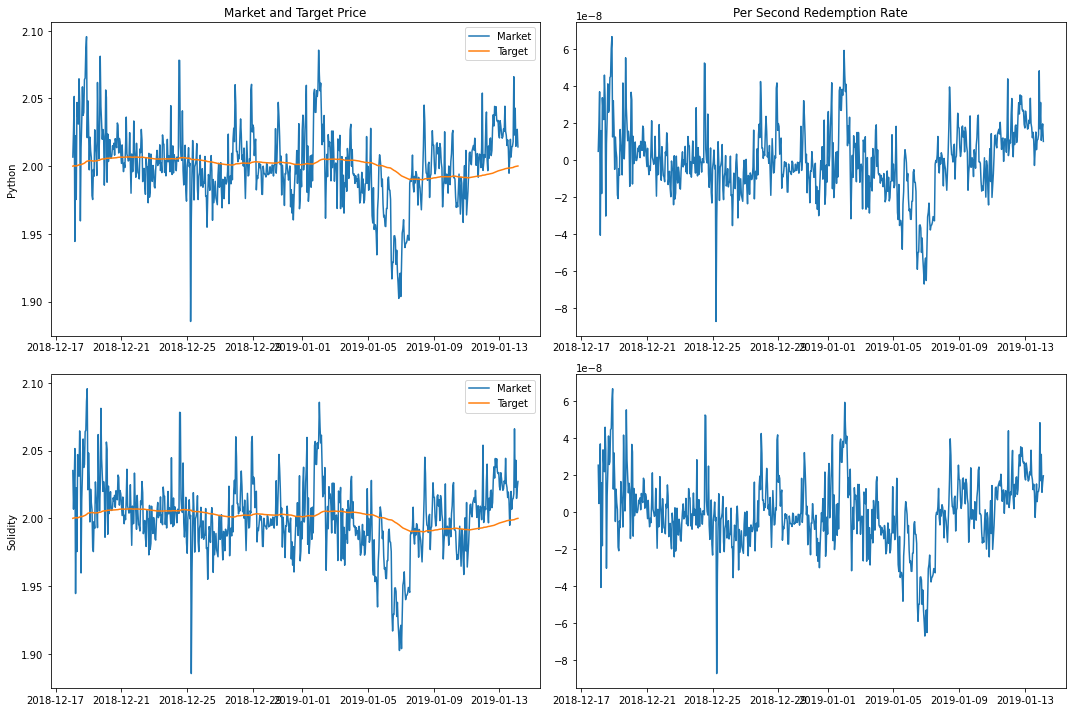

In [47]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15,10))

i = 0
axs.flat[i].plot(combined['timestamp'], combined['market_price'], label='Market')
axs.flat[i].plot(combined['timestamp'], combined['target_price'], label='Target')
axs.flat[i].set_ylabel('Python')
axs.flat[i].set_title('Market and Target Price')
axs.flat[i].legend()

i += 1 
axs.flat[i].plot(combined['timestamp'], combined['target_rate'])
axs.flat[i].set_title('Per Second Redemption Rate')

i += 1 
axs.flat[i].plot(combined['timestamp'], combined['MarketPrice(USD)'], label='Market')
axs.flat[i].plot(combined['timestamp'], combined['RedemptionPrice(USD)'], label='Target')
axs.flat[i].legend()
axs.flat[i].set_ylabel('Solidity')

i += 1 
axs.flat[i].plot(combined['timestamp'], combined['PerSecondRedemptionRate(float)'])

fig.tight_layout()
plt.show()

<AxesSubplot:>

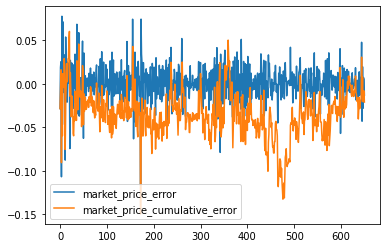

In [60]:
combined['market_price_error'] = combined['market_price'] - combined['MarketPrice(USD)']
combined['market_price_error'].plot(legend=True)
combined['market_price_cumulative_error'] = combined['market_price_error'].cumsum()
combined['market_price_cumulative_error'].plot(legend=True)

In [58]:
combined['market_price_error'].describe()

count    651.000000
mean      -0.000032
std        0.021095
min       -0.116745
25%       -0.010517
50%       -0.000175
75%        0.012344
max        0.077943
Name: market_price_error, dtype: float64

In [59]:
combined['market_price_cumulative_error'].describe()

count    651.000000
mean      -0.034437
std        0.027032
min       -0.149817
25%       -0.047653
50%       -0.034674
75%       -0.019912
max        0.060422
Name: market_price_cumulative_error, dtype: float64